# Lectura de datos crudos y tratamiento

## Importar librerías

In [4]:
import pandas as pd
import numpy as np
import os
import glob
import re
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt

**1. Cargar los datos desde el CSV**

- Leer los datos crudos (IR, Red, ambiente) del archivo CSV.
- Convertir la columna de tiempo a milisegundos para análisis de frecuencia.

**2. Filtrar la señal (opcional pero recomendable)**

- Aplicar un filtro pasaaltos para eliminar el componente de corriente continua (DC).
- Aplicar un filtro pasabajos para eliminar ruido de alta frecuencia.

**3. Detectar picos en la señal de la LED roja (usualmente más fiable que la IR para frecuencia cardíaca)**

- Usar scipy.signal.find_peaks() para detectar los máximos de la onda pulsátil.
- Calcular el tiempo entre picos sucesivos para obtener el periodo de los latidos.

**4. Calcular la frecuencia cardíaca (BPM)**

Usar la fórmula:

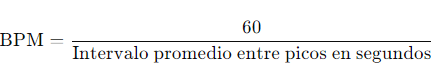

In [5]:
# Extraer el valor real de SpO2 y HR del nombre del archivo (por ejemplo: 'pulsioximetro_98_72.csv')
folder_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos"

# Buscar todos los archivos CSV en la carpeta
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))


datos_pulsioximetro = {}

for file in csv_files:
    filename = os.path.basename(file)  # Obtener solo el nombre del archivo

    # Buscar saturación y pulso en el nombre del archivo
    match = re.search(r"_(\d+)_(\d+)", filename)
    if match:
        saturacion = int(match.group(1))
        pulso = int(match.group(2))
        datos_pulsioximetro[filename] = {"Saturación (%)": saturacion, "Pulso (BPM)": pulso}

# Convertir a un DataFrame para verlo mejor
df_resultados = pd.DataFrame.from_dict(datos_pulsioximetro, orient="index")

# Mostrar resultados
print(df_resultados)




                             Saturación (%)  Pulso (BPM)
raw_data_92_103_deporte.csv              92          103
raw_data_92_76.csv                       92           76
raw_data_93_100.csv                      93          100
raw_data_93_116.csv                      93          116
raw_data_93_79.csv                       93           79
raw_data_95_77_01_03.csv                 95           77
raw_data_95_77_2.csv                     95           77
raw_data_95_80.csv                       95           80
raw_data_95_83.csv                       95           83
raw_data_95_87_apnea.csv                 95           87
raw_data_95_99.csv                       95           99
raw_data_96_74_papa.csv                  96           74
raw_datos_90_130.csv                     90          130



Procesando archivo: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\raw_data_92_103_deporte.csv
Saturación real: 92%
Pulso real: 103 BPM
Pulso estimado: 543.07 BPM


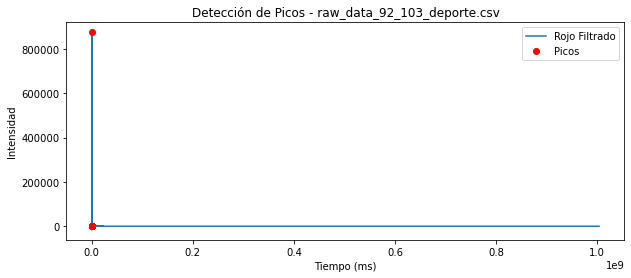


Procesando archivo: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\raw_data_92_76.csv
Saturación real: 92%
Pulso real: 76 BPM
Pulso estimado: 83.59 BPM


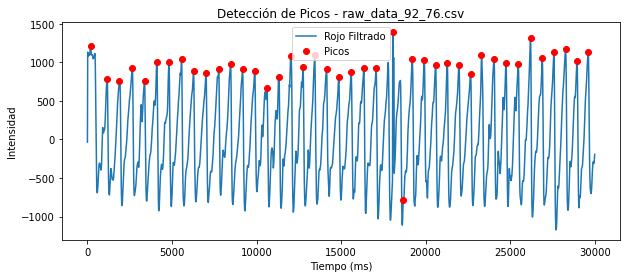


Procesando archivo: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\raw_data_93_100.csv
Saturación real: 93%
Pulso real: 100 BPM
Pulso estimado: 74.92 BPM


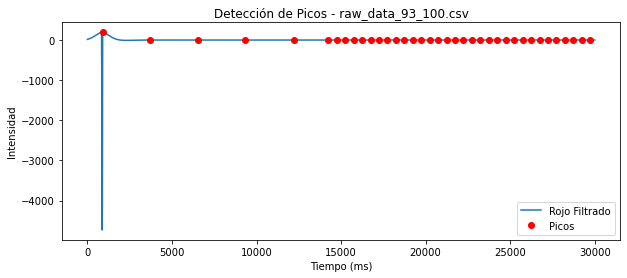


Procesando archivo: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\raw_data_93_116.csv
Saturación real: 93%
Pulso real: 116 BPM
Pulso estimado: nan BPM


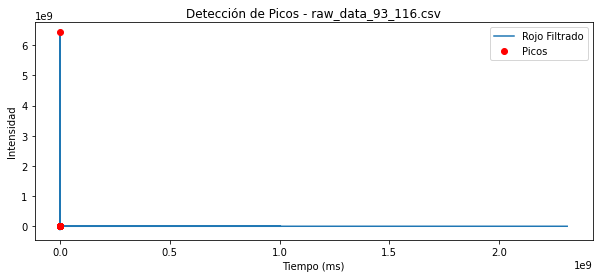


Procesando archivo: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\raw_data_93_79.csv
Saturación real: 93%
Pulso real: 79 BPM
Pulso estimado: 50.98 BPM


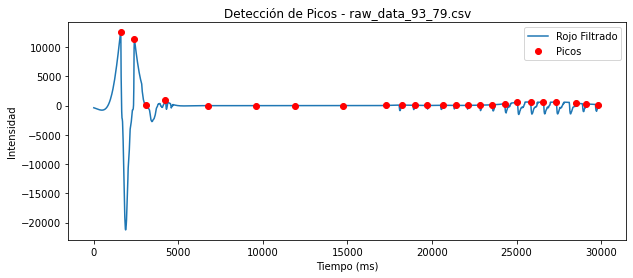


Procesando archivo: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\raw_data_95_77_01_03.csv
Saturación real: 95%
Pulso real: 77 BPM
Pulso estimado: 600.78 BPM


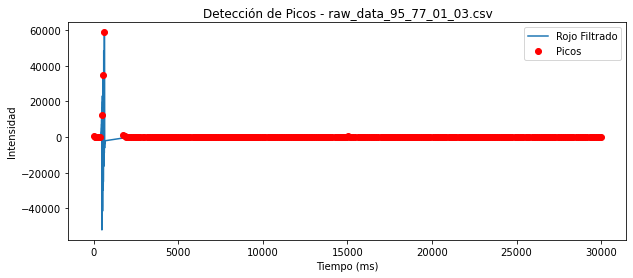


Procesando archivo: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\raw_data_95_77_2.csv
Saturación real: 95%
Pulso real: 77 BPM
Pulso estimado: 80.09 BPM


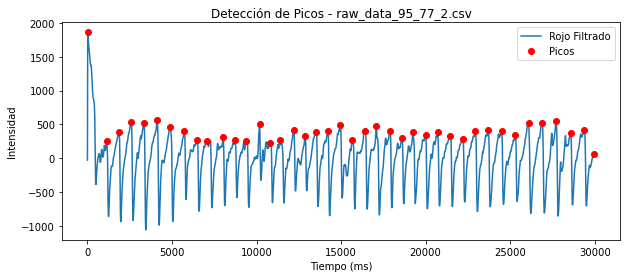


Procesando archivo: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\raw_data_95_80.csv
Saturación real: 95%
Pulso real: 80 BPM
Pulso estimado: 75.18 BPM


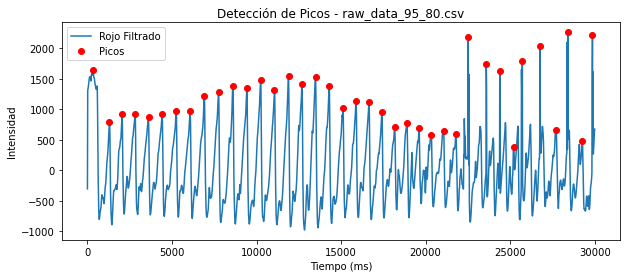


Procesando archivo: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\raw_data_95_83.csv
Saturación real: 95%
Pulso real: 83 BPM
Pulso estimado: nan BPM


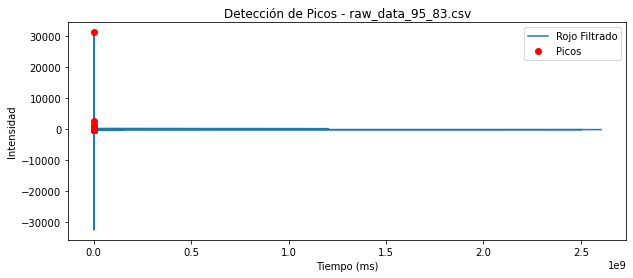


Procesando archivo: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\raw_data_95_87_apnea.csv
Saturación real: 95%
Pulso real: 87 BPM
Pulso estimado: nan BPM


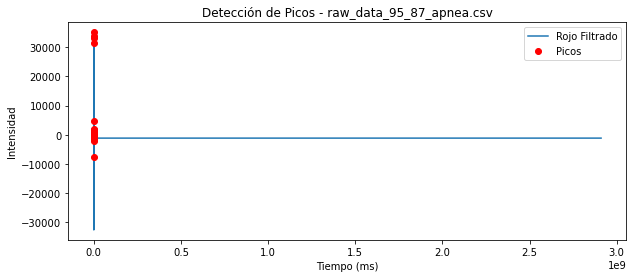


Procesando archivo: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\raw_data_95_99.csv
Saturación real: 95%
Pulso real: 99 BPM
Pulso estimado: 93.62 BPM


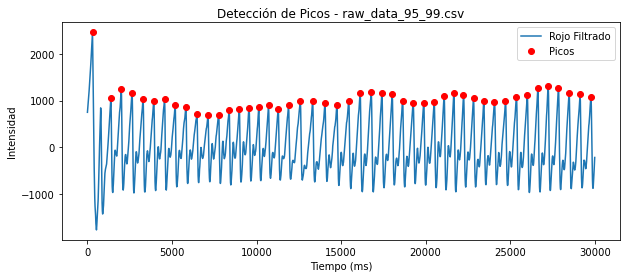


Procesando archivo: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\raw_data_96_74_papa.csv
Saturación real: 96%
Pulso real: 74 BPM
Pulso estimado: 628.50 BPM


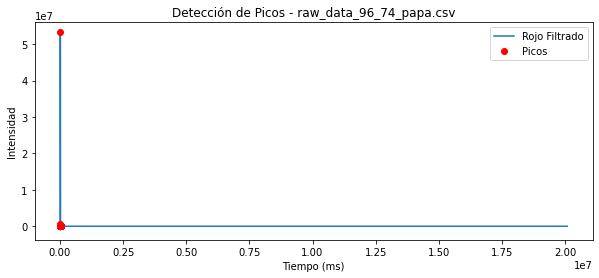


Procesando archivo: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\raw_datos_90_130.csv
Saturación real: 90%
Pulso real: 130 BPM
Pulso estimado: 590.71 BPM


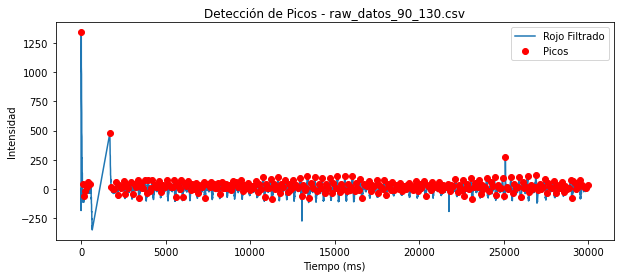

In [8]:
# Ruta de la carpeta con los archivos CSV
folder_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos"

# Listar todos los archivos CSV en la carpeta
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Función para aplicar un filtro Butterworth pasaaltos
def highpass_filter(data, cutoff=0.5, fs=60, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

# Procesar cada archivo
for file in csv_files:
    print(f"\nProcesando archivo: {file}")

    # Extraer SpO2 y pulso del nombre del archivo
    filename = os.path.basename(file)
    match = re.search(r"_(\d+)_(\d+)", filename)
    if match:
        saturacion_real = int(match.group(1))
        pulso_real = int(match.group(2))
    else:
        saturacion_real, pulso_real = None, None  # En caso de que el formato no coincida

    # Cargar datos
    df = pd.read_csv(file, delimiter=";")  # Prueba con coma


    # Asegurar que las columnas están en el orden correcto
    df.columns = ["Tiempo", "IR", "IR_Amb", "Rojo", "Rojo_Amb"]

    # Filtrar la señal roja para eliminar ruido de baja frecuencia
    df["Rojo_filtrado"] = highpass_filter(df["Rojo"], cutoff=0.5, fs=60, order=2)

    # Detectar picos en la señal roja
    peaks, _ = find_peaks(df["Rojo_filtrado"], distance=30)  # Ajustar distancia según el muestreo

    # Calcular tiempos entre picos sucesivos
    tiempos = df["Tiempo"].iloc[peaks].values
    intervalos = np.diff(tiempos) / 1000  # Convertir de ms a segundos

    # Calcular BPM si hay intervalos detectados
    if len(intervalos) > 0:
        bpm_estimado = 60 / np.mean(intervalos)
    else:
        bpm_estimado = None

    # Mostrar resultados
    print(f"Saturación real: {saturacion_real}%")
    print(f"Pulso real: {pulso_real} BPM")
    print(f"Pulso estimado: {bpm_estimado:.2f} BPM")

    # Graficar señal y picos detectados
    plt.figure(figsize=(10, 4))
    plt.plot(df["Tiempo"], df["Rojo_filtrado"], label="Rojo Filtrado")
    plt.plot(df["Tiempo"].iloc[peaks], df["Rojo_filtrado"].iloc[peaks], "ro", label="Picos")
    plt.xlabel("Tiempo (ms)")
    plt.ylabel("Intensidad")
    plt.legend()
    plt.title(f"Detección de Picos - {filename}")
    plt.show()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import os
from scipy.signal import find_peaks

# Ruta donde tienes los archivos CSV
ruta_datos = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos"

# Función para calcular SpO2
def calcular_spo2(ir, red):
    ac_ir = np.std(ir)    # Componente AC (desviación estándar)
    dc_ir = np.mean(ir)   # Componente DC (media)
    ac_red = np.std(red)
    dc_red = np.mean(red)

    # Calcular el coeficiente R
    R = (ac_red / dc_red) / (ac_ir / dc_ir)

    # Fórmula empírica
    spo2 = 110 - 25 * R
    return spo2

# Función para calcular la frecuencia cardíaca (HR)
def calcular_hr(senal, tiempo):
    # Detectar picos en la señal IR (ajustar 'height' y 'distance' si es necesario)
    picos, _ = find_peaks(senal, height=1000, distance=20)

    # Calcular el tiempo entre picos (en segundos)
    tiempos_picos = tiempo[picos]
    intervalos = np.diff(tiempos_picos)

    # Calcular HR (latidos por minuto)
    if len(intervalos) > 0:
        hr = 60 / np.mean(intervalos)
        return hr
    else:
        return np.nan

# Función para suavizar las señales (filtro de media móvil)
def suavizar(senal, ventana=5):
    return np.convolve(senal, np.ones(ventana) / ventana, mode='same')

# Listar los archivos CSV en la carpeta
archivos = [f for f in os.listdir(ruta_datos) if f.endswith('.csv')]

# Almacenar resultados
resultados = []

# Procesar cada archivo CSV
for archivo in archivos:
    # Extraer SpO₂ y HR reales del nombre del archivo (ejemplo: raw_data_93_100.csv)
    valores = re.findall(r'\d+', archivo)
    if len(valores) >= 2:
        spo2_real, hr_real = map(int, valores[-2:])
    else:
        print(f"No se pudieron extraer los valores del archivo: {archivo}")
        continue

    # Ruta completa del archivo
    ruta_completa = os.path.join(ruta_datos, archivo)

    # Cargar el CSV
    df = pd.read_csv(ruta_completa)

    # Validar que el CSV tenga las columnas correctas
    if not all(col in df.columns for col in ["Tiempo (ms)", "IR", "RED"]):
        print(f"Formato incorrecto en: {archivo}")
        continue

    # Convertir tiempo a segundos
    df["Tiempo (s)"] = df["Tiempo (ms)"] / 1000

    # Suavizar las señales
    df["IR_suave"] = suavizar(df["IR"])
    df["RED_suave"] = suavizar(df["RED"])

    # Calcular HR y SpO2
    hr_calculado = calcular_hr(df["IR_suave"].values, df["Tiempo (s)"].values)
    spo2_calculado = calcular_spo2(df["IR_suave"], df["RED_suave"])

    # Calcular errores
    error_spo2 = abs(spo2_calculado - spo2_real)
    error_hr = abs(hr_calculado - hr_real)

    # Guardar los resultados
    resultados.append({
        "Archivo": archivo,
        "SpO₂ real": spo2_real,
        "HR real": hr_real,
        "SpO₂ calculado": round(spo2_calculado, 2),
        "HR calculado": round(hr_calculado, 2),
        "Error SpO₂": round(error_spo2, 2),
        "Error HR": round(error_hr, 2)
    })

    # Visualizar las señales
    plt.figure(figsize=(12, 6))
    plt.plot(df["Tiempo (s)"], df["IR_suave"], label="IR (suavizado)")
    plt.plot(df["Tiempo (s)"], df["RED_suave"], label="RED (suavizado)")
    plt.title(f"{archivo} - SpO₂: {spo2_calculado:.2f}% | HR: {hr_calculado:.2f} BPM")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Intensidad")
    plt.legend()
    plt.show()

# Crear un DataFrame con los resultados
df_resultados = pd.DataFrame(resultados)

# Mostrar la tabla resumen
print(df_resultados)

# Guardar los resultados en un CSV
df_resultados.to_csv(r"C:\Users\Elena\Desktop\resultados_estimaciones.csv", index=False)

print("¡Análisis completado! Los resultados se han guardado en 'resultados_estimaciones.csv'")


Formato incorrecto en: raw_data_92_103_deporte.csv
Formato incorrecto en: raw_data_92_76.csv
Formato incorrecto en: raw_data_93_100.csv
Formato incorrecto en: raw_data_93_116.csv
Formato incorrecto en: raw_data_93_79.csv
Formato incorrecto en: raw_data_95_77_01_03.csv
Formato incorrecto en: raw_data_95_77_2.csv
Formato incorrecto en: raw_data_95_80.csv
Formato incorrecto en: raw_data_95_83.csv
Formato incorrecto en: raw_data_95_87_apnea.csv
Formato incorrecto en: raw_data_95_99.csv
Formato incorrecto en: raw_data_96_74_papa.csv
Formato incorrecto en: raw_datos_90_130.csv
Empty DataFrame
Columns: []
Index: []
¡Análisis completado! Los resultados se han guardado en 'resultados_estimaciones.csv'


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import glob  # Para encontrar todos los archivos CSV automáticamente

# Ruta donde están los archivos CSV
carpeta_csv = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos"

# Obtener la lista de archivos CSV en la carpeta
csv_files = glob.glob(carpeta_csv + "*.csv")

# Crear una figura para mostrar todas las señales en subgráficos
fig, axes = plt.subplots(len(csv_files), 1, figsize=(10, 5 * len(csv_files)))

# Si solo hay un archivo, aseguramos que "axes" sea una lista
if len(csv_files) == 1:
    axes = [axes]

# Iterar sobre cada archivo y graficar su señal IR
for i, file in enumerate(csv_files):
    df = pd.read_csv(file, sep=",")  # Asegúrate de que el separador es correcto
    df = df[(df["Tiempo (ms)"] >= 0) & (df["Tiempo (ms)"] <= 30000)]  # Filtrar datos erróneos
    
    axes[i].plot(df["Tiempo (ms)"], df["IR"])
    axes[i].set_xlabel("Tiempo (ms)")
    axes[i].set_ylabel("Señal IR")
    axes[i].set_title(f"Señal IR - {file.split('/')[-1]}")

plt.tight_layout()
plt.show()


ValueError: Number of rows must be a positive integer, not 0

<Figure size 720x0 with 0 Axes>